In [1]:
###Imports###

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
###Importing dataset###
data_dir = 'data'
#data_dir value is environment specific
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validate')
test_dir = os.path.join(data_dir, 'test')

#util = Util(data_dir)
#util.create_augmentations()

# Defining transformations
transform = transforms.Compose([
    transforms.Resize((256, 512)),  # Resize images to 256x512
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Loading datasets using ImageFolder
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [3]:
###Model setup###

#Set GPU as processing device if available else use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Loading pre-trained ResNet
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

#Replacing the avgpool layer with Global Average Pooling to support any input picture size
#model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global/Adaptive pooling
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_ftrs, 1),  # Change to a single output
    nn.Sigmoid()             # sigmoid for binary classification
)

Using device: cuda


In [4]:
###loss function and optimizer###
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
###Training the model###

# Ensuring the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Clear cache after each epoch
    torch.cuda.empty_cache()
    # Early stopping
    if val_loss < 0.1 and train_loss < 0.1: break

# Save the model
model_path = os.path.join('saved_models', 'binary_classifier_model.pth')
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Create directory if it doesn't exist
torch.save(model.state_dict(), model_path)
print("Model saved as binary_classifier_model.pth")

Epoch 1/30, Train Loss: 0.4251, Val Loss: 0.4214
Epoch 2/30, Train Loss: 0.1990, Val Loss: 0.1954
Epoch 3/30, Train Loss: 0.1684, Val Loss: 0.2455
Epoch 4/30, Train Loss: 0.0870, Val Loss: 0.3505
Epoch 5/30, Train Loss: 0.0676, Val Loss: 0.3995
Epoch 6/30, Train Loss: 0.0829, Val Loss: 0.2396
Epoch 7/30, Train Loss: 0.0541, Val Loss: 0.1112
Epoch 8/30, Train Loss: 0.0395, Val Loss: 0.1028
Epoch 9/30, Train Loss: 0.0266, Val Loss: 0.1245
Epoch 10/30, Train Loss: 0.0674, Val Loss: 0.0845
Model saved as binary_classifier_model.pth


Images classified as class 0:
data\validate\bad\0f000f51-db56-4c09-9266-37da34932b78.webp
data\validate\bad\177fac96-2191-4884-b9f4-835d5ba0de7d.webp
data\validate\bad\82b6ef05-1fe6-4422-ad06-26642c41a8b2.webp
data\validate\bad\c0d166da-fb03-4da0-9855-aaf636fefa77.webp
data\validate\bad\c731a60e-2fbe-4e13-9523-21bce9a9fc1e.webp

Good images falsely classified as bad (False Negatives):


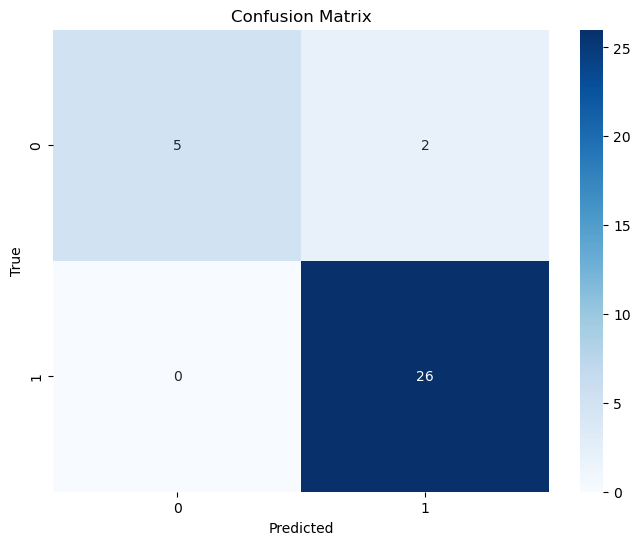

Accuracy: 0.9394
Recall: 1.0000
Precision: 0.9286


In [6]:

###Plotting confusing matrix###

# Initialize lists to store true and predicted labels
true_labels = []
pred_labels = []

# Get predictions on test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Find indices where predictions were class 0
class_0_indices = [i for i, pred in enumerate(pred_labels) if pred == 0]

# Print the filenames of images predicted as bad (class 0)
print("Images classified as class 0:")
for idx in class_0_indices:
    # Get the filename from the dataset
    img_path = val_dataset.samples[idx][0]
    print(img_path)

# Print falsely classified images (good images classified as bad)
print("\nGood images falsely classified as bad (False Negatives):")
for idx in class_0_indices:
    if true_labels[idx] == 1:  # If true label is 1 (good) but predicted as 0 (bad)
        img_path = val_dataset.samples[idx][0]
        print(img_path)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###Model evaluation scores###
accuracy = accuracy_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")